# EDA and Feature Engineering

本 Notebook 聚焦於：
- 從 URL 下載雙向流（bidirectional flow）資料
- 讀取 `.binetflow` 格式檔案
- 分析欄位型別、資料量與缺失值
- **長尾分佈分析**：發現哪些特徵呈現長尾分佈，並決定如何處理
- **UDP/TCP 切分分析**：分析不同協議的流量特徵差異
- **時間特徵階段化設計**：從基本時間特徵到聚合特徵的漸進式設計
- **階段3：時間窗口聚合**：按源IP的每分鐘聚合，捕捉行為模式
- **階段4：雙向流 Pair 聚合**：按IP Pair的每分鐘聚合，捕捉Session級別模式
- 進行初步的探索性資料分析

## 思考過程

這個 Notebook 展示了如何：
1. **發現長尾分佈**：通過計算偏度（skewness）和峰度（kurtosis），發現關鍵特徵（如 TotBytes, Dur 等）呈現嚴重的長尾分佈
2. **決定要切 UDP/TCP**：通過協議切分分析，發現 UDP 和 TCP 流量的特徵分佈有顯著差異，因此決定分別處理
3. **階段化特徵工程**：從單筆流特徵（階段1-2）到聚合特徵（階段3-4），逐步捕捉不同層級的異常行為模式


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import datetime
import warnings

# 直接使用絕對路徑
PROJECT_ROOT = Path(r"C:\MyVS\NetworkAnomalyDetection")

# 將專案根目錄加入 Python 路徑（必須在匯入 src 模組之前）
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 過濾警告
warnings.filterwarnings('ignore', category=UserWarning, message=r'.*glyph.*U\+2212.*')
warnings.filterwarnings('ignore', category=UserWarning, message='.*Glyph.*missing from font.*')
warnings.filterwarnings('ignore', category=UserWarning, message='.*CJK UNIFIED IDEOGRAPH.*')
warnings.filterwarnings('ignore', message=r'.*Font.*does not have a glyph.*')
warnings.filterwarnings('ignore', message=r'.*substituting with a dummy symbol.*')
warnings.filterwarnings('ignore', message=r'.*U\+2212.*')
# 隱藏 applymap 的 FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning, message=r'.*DataFrame\.applymap.*')

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# matplotlib 設定
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rc('axes', unicode_minus=False)

# 設定中文字型（Windows）
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']

# 從 src 模組導入特徵提取和分析函數
from src.data_loader import DataLoaderFactory, DataSourceType
from src.features import (
    extract_features_with_analysis,
    extract_features,  # 使用包裝版本，自動過濾 PySpark 冗長訊息
    analyze_long_tail_distribution,
    analyze_protocol_split,
    visualize_time_window_features,
    visualize_bidirectional_symmetry,
    visualize_protocol_comparison
)


In [2]:
# 載入資料
parquet_path = PROJECT_ROOT / "data" / "processed" / "capture20110817_cleaned_spark.parquet"

if parquet_path.exists():
    print(f"✅ 使用 Pandas 讀取 Parquet 檔案: {parquet_path}")
    df_raw = pd.read_parquet(parquet_path, engine='pyarrow')
    print(f"✅ 讀取完成：{len(df_raw):,} 筆資料")
else:
    print(f"⚠️  Parquet 檔案不存在: {parquet_path}")
    print("   使用標準載入器從 CSV 讀取...")
    loader = DataLoaderFactory.create(DataSourceType.BIDIRECTIONAL_BINETFLOW)
    df_raw = loader.load()

# 清洗資料（使用標準載入器的清洗方法）
loader = DataLoaderFactory.create(DataSourceType.BIDIRECTIONAL_BINETFLOW)
df = loader.clean(df_raw)

print(f"✅ 資料載入完成：{len(df):,} 筆")
print(f"   時間範圍：{df['StartTime'].min()} ~ {df['StartTime'].max()}")

# 檢視前幾筆資料
df.head()


✅ 使用 Pandas 讀取 Parquet 檔案: C:\MyVS\NetworkAnomalyDetection\data\processed\capture20110817_cleaned_spark.parquet
✅ 讀取完成：2,087,508 筆資料
✅ 資料載入完成：2,087,508 筆
   時間範圍：2011-08-17 11:34:49.436881 ~ 2011-08-17 17:12:13.867435


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011-08-17 11:34:49.436881,1823.088379,udp,46.196.43.16,6881.0,<->,147.32.84.118,6881.0,CON,0.0,0.0,2,214,107,flow=Background-UDP-Established
1,2011-08-17 11:39:01.485380,2005.431641,udp,82.1.195.156,6881.0,<->,147.32.84.118,6881.0,CON,0.0,0.0,2,214,107,flow=Background-UDP-Established
2,2011-08-17 11:40:19.495285,1973.646729,udp,151.28.221.122,6881.0,<->,147.32.84.118,6881.0,CON,0.0,0.0,2,214,107,flow=Background-UDP-Established
3,2011-08-17 12:01:01.780520,3599.997803,udp,188.75.133.98,16200.0,<->,147.32.86.125,35248.0,CON,0.0,0.0,409227,207547419,182657149,flow=Background-UDP-Established
4,2011-08-17 12:01:01.782109,2059.387451,tcp,119.252.172.92,59067.0,<?>,147.32.84.14,80.0,RA_PA,0.0,0.0,224275,266462578,3199174,flow=Background


## 基本資料探索


In [3]:
# 基本資訊與資料型別
print("資料型別:")
print(df.dtypes)
print(f"\n記憶體使用: {df.memory_usage(deep=True).sum() / (1024 ** 2):,.2f} MB")

# 缺失值檢查
row_count = len(df)
missing = (
    df.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda d: d["missing_count"] / row_count * 100)
    .sort_values("missing_count", ascending=False)
)

if missing["missing_count"].sum() == 0:
    print("\n✅ 完美！沒有任何缺失值。")
else:
    print("\n⚠️ 發現缺失值：")
    # 🔥 格式化缺失值統計
    missing_formatted = missing[missing["missing_count"] > 0].copy()
    missing_formatted['missing_count'] = missing_formatted['missing_count'].apply(lambda x: f'{x:,}')
    missing_formatted['missing_pct'] = missing_formatted['missing_pct'].apply(lambda x: f'{x:.2f}%')
    print(missing_formatted)

# 基本統計資訊
print("\n基本統計資訊：")

# 🔥 格式化數字顯示函數
def format_number(x):
    """格式化數字：小數用逗號分隔，大數用科學記號但更易讀"""
    if pd.isna(x):
        return x
    abs_x = abs(x)
    if abs_x < 1:
        return f'{x:.4f}'
    elif abs_x < 1000:
        return f'{x:.2f}'
    elif abs_x < 1e6:
        return f'{x:,.0f}'
    elif abs_x < 1e9:
        return f'{x/1e6:.2f}M'  # 百萬
    elif abs_x < 1e12:
        return f'{x/1e9:.2f}B'  # 十億
    else:
        return f'{x:.2e}'

# 獲取數值型欄位的統計資訊
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    stats = df[numeric_cols].describe()
    # 應用格式化
    stats_formatted = stats.applymap(format_number)
    print(stats_formatted)
else:
    print("   ⚠️ 沒有數值型欄位")

資料型別:
StartTime    datetime64[ns]
Dur                 float64
Proto                object
SrcAddr              object
Sport               float64
Dir                  object
DstAddr              object
Dport               float64
State                object
sTos                float64
dTos                float64
TotPkts               int32
TotBytes              int64
SrcBytes              int32
Label                object
dtype: object

記憶體使用: 853.30 MB

⚠️ 發現缺失值：
      missing_count missing_pct
dTos        173,232       8.30%
Dport        24,470       1.17%
Sport        23,862       1.14%
sTos          9,031       0.43%
State             3       0.00%

基本統計資訊：
          Dur   Sport   Dport    sTos    dTos TotPkts TotBytes SrcBytes
count   2.09M   2.06M   2.06M   2.08M   1.91M   2.09M    2.09M    2.09M
mean   294.60  35,498   6,723  0.0315  0.0004   55.29   39,082    7,418
std    837.56  20,724  12,062    2.39  0.0332  12,620    5.39M    1.65M
min    0.0000    1.00    1.00  0.0000  0.0

【標籤分佈分析】

1. 原始標籤統計：
                                             數量   百分比 (%)
Label                                                    
flow=To-Background-UDP-CVUT-DNS-Server  781,402  37.4323%
flow=Background-UDP-Established         615,055  29.4636%
flow=Background-TCP-Established         175,576   8.4108%
flow=Background-Established-cmpgw-CVUT  125,013   5.9886%
flow=Background-UDP-Attempt              79,520   3.8093%
flow=Background-TCP-Attempt              28,937   1.3862%
flow=Background                          28,018   1.3422%
flow=To-Background-CVUT-Proxy            16,407   0.7860%
flow=From-Normal-V50-Stribrek            15,806   0.7572%
flow=From-Botnet-V50-1-UDP-DNS           15,115   0.7241%

2. 二元標籤統計（正常 vs 異常）：
   總樣本數：2,087,508
   正常樣本（0）：1,902,521 (91.1384%)
   異常樣本（1）：184,987 (8.8616%)
   不平衡比例：10.28:1 (正常:異常)

3. 標籤分佈視覺化：


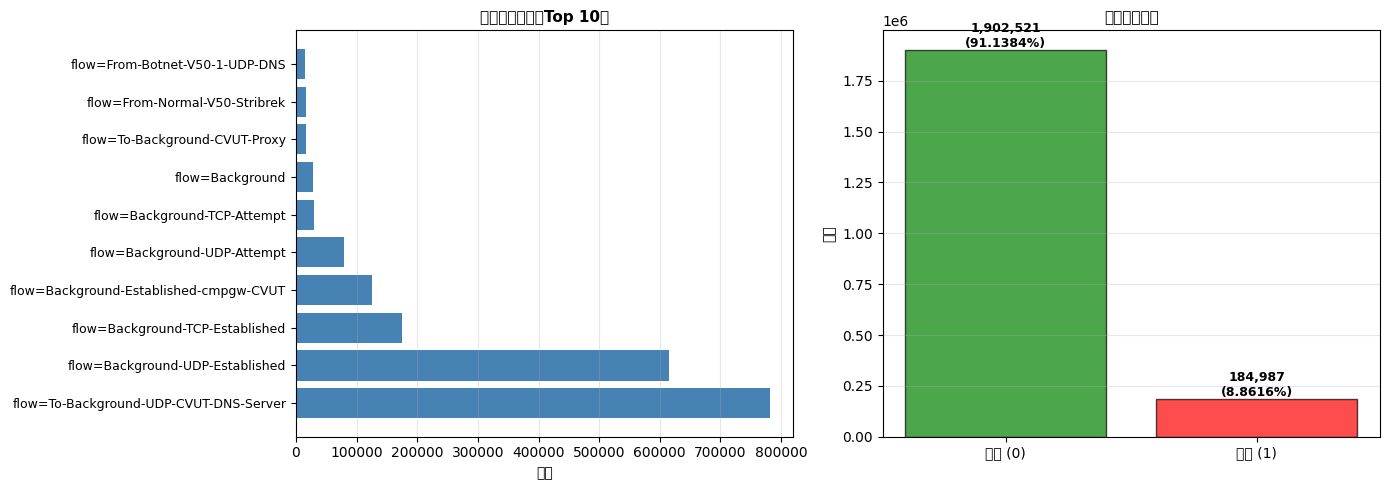


✅ 標籤分析完成


In [4]:
# 標籤分佈分析
print("=" * 60)
print("【標籤分佈分析】")
print("=" * 60)

if 'Label' in df.columns:
    # 1. 原始標籤統計
    print("\n1. 原始標籤統計：")
    label_counts = df['Label'].value_counts()
    label_percentages = df['Label'].value_counts(normalize=True) * 100
    
    label_stats = pd.DataFrame({
        '數量': label_counts.values,
        '百分比 (%)': label_percentages.values
    }, index=label_counts.index)
    
    # 格式化顯示
    label_stats['數量'] = label_stats['數量'].apply(lambda x: f'{x:,}')
    label_stats['百分比 (%)'] = label_stats['百分比 (%)'].apply(lambda x: f'{x:.4f}%')
    
    # 只顯示前10個
    print(label_stats.head(10).to_string())
    
    # 2. 二元標籤統計（正常 vs 異常）
    print("\n2. 二元標籤統計（正常 vs 異常）：")
    from src.label_processor import convert_label_to_binary, get_label_statistics
    
    # 轉換為二元標籤
    df_with_binary = convert_label_to_binary(df.copy(), verbose=False)
    
    # 計算二元標籤統計
    binary_stats = get_label_statistics(df_with_binary, label_column='Label', binary_column='label_binary')
    
    # 修正：使用正確的鍵名
    total_count = binary_stats['total_count']
    normal_count = binary_stats['normal_count']
    anomaly_count = binary_stats['anomaly_count']
    normal_ratio = binary_stats['normal_ratio']
    anomaly_ratio = binary_stats['anomaly_ratio']
    
    print(f"   總樣本數：{total_count:,}")
    print(f"   正常樣本（0）：{normal_count:,} ({normal_ratio*100:.4f}%)")
    print(f"   異常樣本（1）：{anomaly_count:,} ({anomaly_ratio*100:.4f}%)")
    
    # 計算不平衡比例
    if anomaly_count > 0:
        imbalance_ratio = normal_count / anomaly_count
        print(f"   不平衡比例：{imbalance_ratio:.2f}:1 (正常:異常)")
    else:
        print(f"   ⚠️  警告：沒有異常樣本")
    
    # 3. 視覺化標籤分佈
    print("\n3. 標籤分佈視覺化：")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左圖：原始標籤分佈（Top 10）
    top_labels = label_counts.head(10)
    axes[0].barh(range(len(top_labels)), top_labels.values, color='steelblue')
    axes[0].set_yticks(range(len(top_labels)))
    axes[0].set_yticklabels(top_labels.index, fontsize=9)
    axes[0].set_xlabel('數量', fontsize=10)
    axes[0].set_title('原始標籤分佈（Top 10）', fontsize=11, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # 右圖：二元標籤分佈
    binary_counts = df_with_binary['label_binary'].value_counts()
    colors = ['green', 'red']
    labels = ['正常 (0)', '異常 (1)']
    axes[1].bar(labels, binary_counts.values, color=colors, alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('數量', fontsize=10)
    axes[1].set_title('二元標籤分佈', fontsize=11, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # 在柱狀圖上顯示數值和百分比
    for i, (label, count) in enumerate(binary_counts.items()):
        percentage = (count / len(df_with_binary)) * 100
        axes[1].text(i, count, f'{count:,}\n({percentage:.4f}%)', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ 標籤分析完成")
else:
    print("⚠️  資料中沒有 'Label' 欄位，無法進行標籤分析")

### 欄位推測
1. 時間相關
   - StartTime (object): 流開始時間（通常為時間戳記字串，如 "2011-08-17 12:01:01.780"）
Dur (float64): 流的持續時間（秒）
2. 網路層資訊
   - Proto (object): 通訊協定（如 "TCP", "UDP", "ICMP"）
   - SrcAddr (object): 來源 IP 位址
   - Sport (object): 來源埠號
   - DstAddr (object): 目的 IP 位址
   - Dport (object): 目的埠號
3. 方向與狀態
   - Dir (object): 流的方向（如 "->" 或 "<->"，表示單向或雙向）
   - State (object): TCP 狀態（如 "EST", "FIN", "RST"；UDP 可能為 "-"）
4. 服務品質
   - sTos (float64): 來源端 Type of Service（服務類型）
   - dTos (float64): 目的端 Type of Service
5. 流量統計
   - TotPkts (int64): 總封包數（雙向合計）
   - TotBytes (int64): 總位元組數（雙向合計）
   - SrcBytes (int64): 來源端位元組數（從來源到目的）
6. 標籤
   - Label (object): 標籤（如 "Background", "Botnet", "Legacy"）

## 特徵提取與分析

使用 `src.features` 模組進行特徵提取和分析。


✅ 特徵提取完成（階段1）：2,087,508 筆，36 個特徵

新增的特徵：
['DstBytes', 'flow_ratio', 'bytes_symmetry', 'src_ratio', 'dst_ratio', 'packet_size', 'bytes_per_second', 'packets_per_second', 'is_scanning', 'hour', 'day_of_week', 'day_of_month', 'is_weekend', 'is_work_hour', 'is_night', 'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week', 'sin_day_of_month', 'cos_day_of_month']

💡 提示：這是階段1的特徵，後續章節將展示階段3和階段4的聚合特徵

【長尾分佈分析】


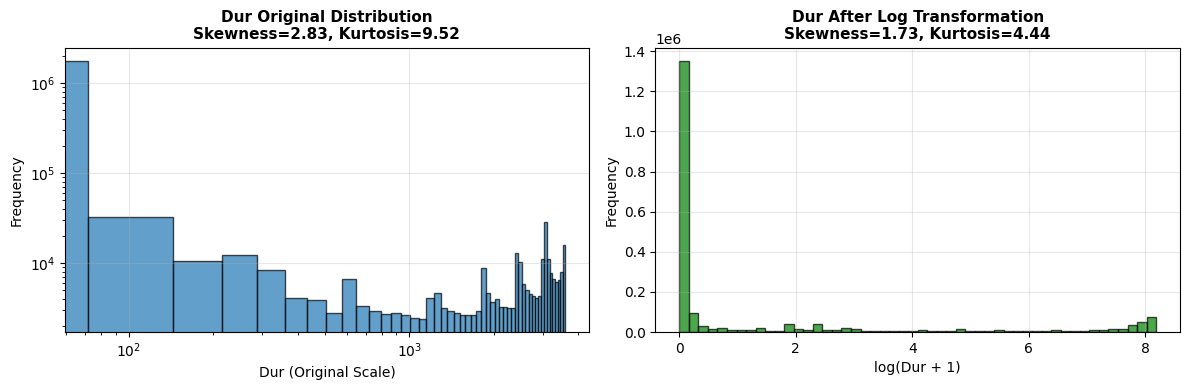

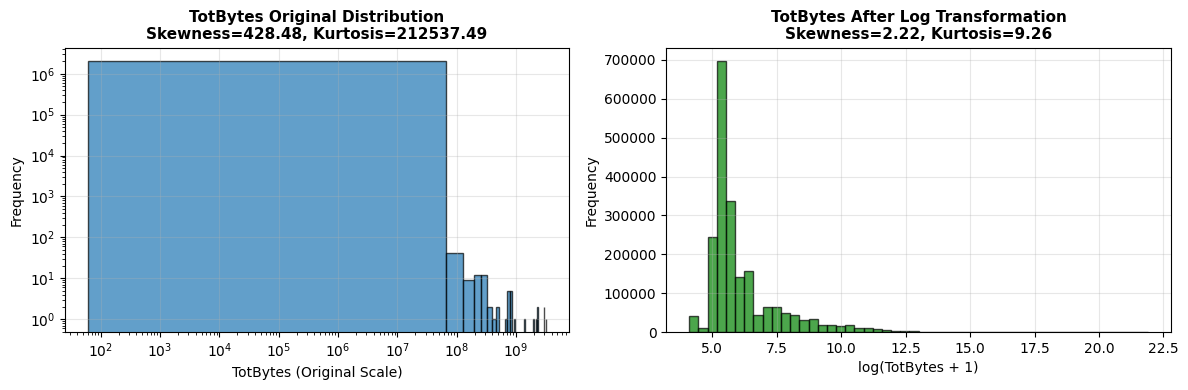

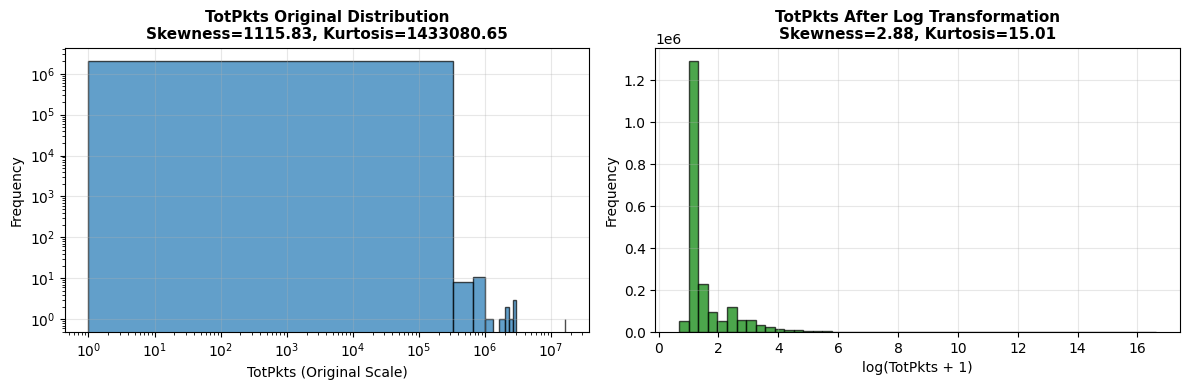

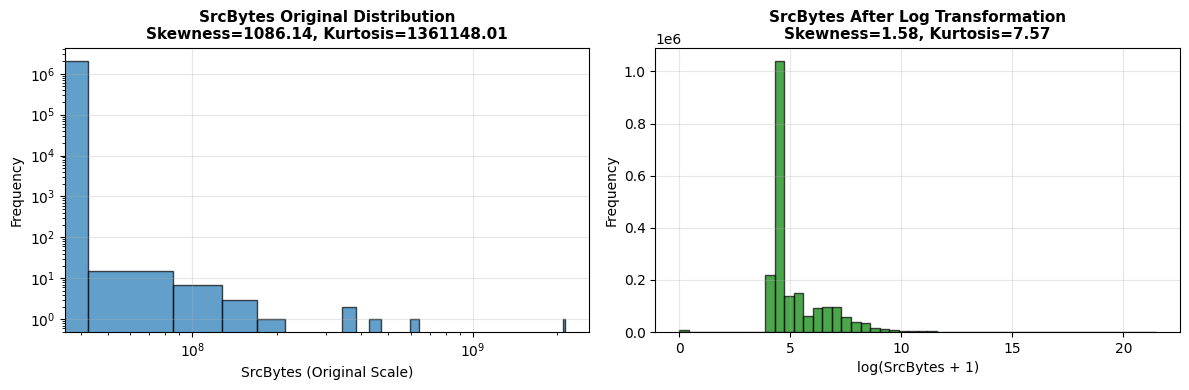

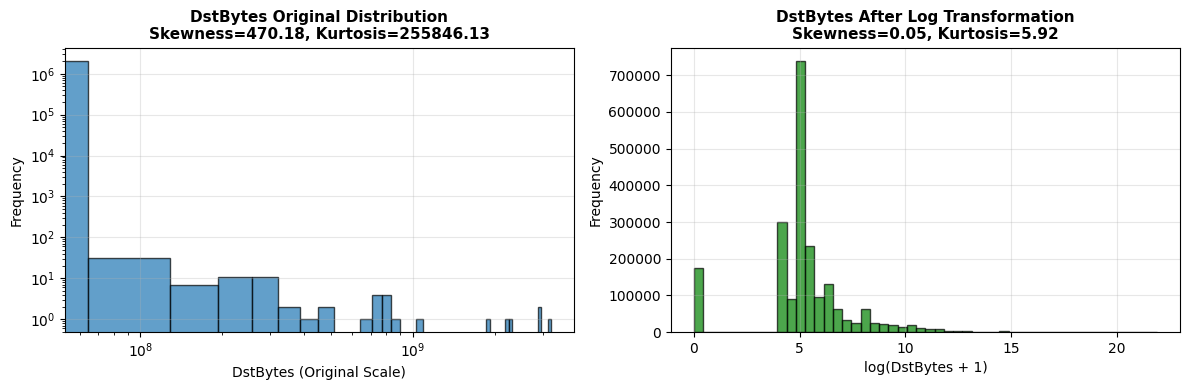

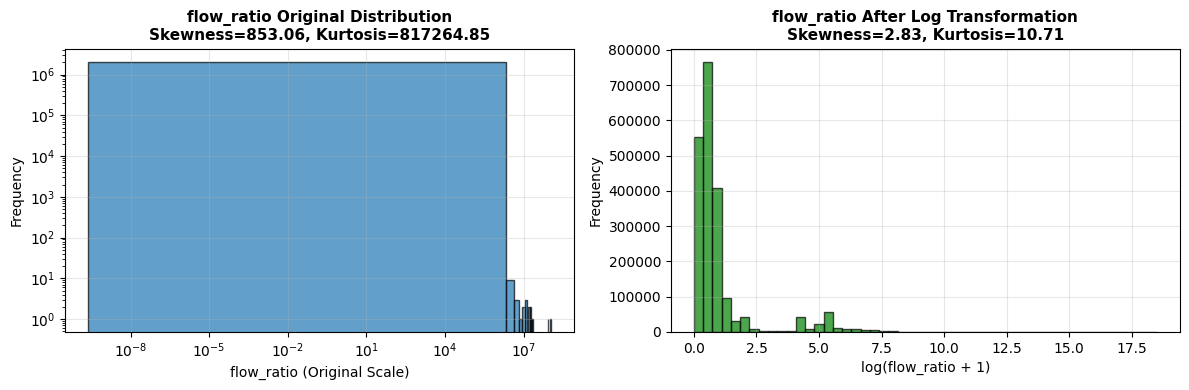

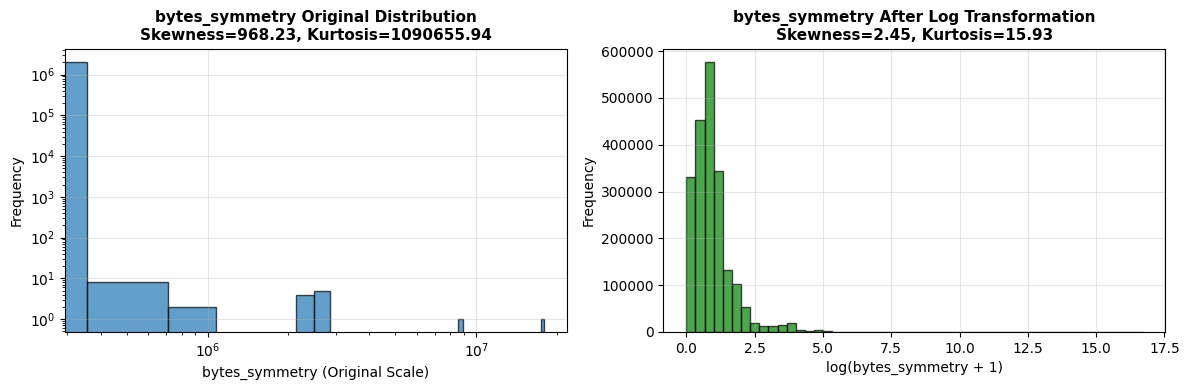

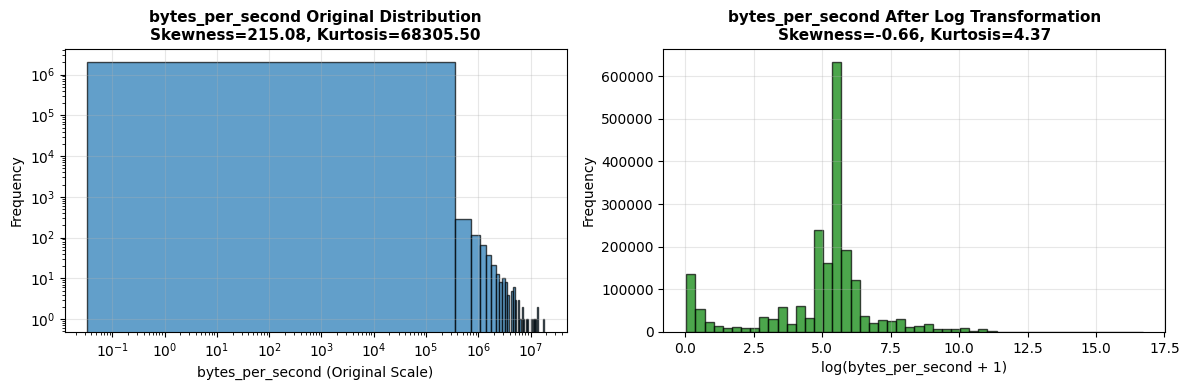

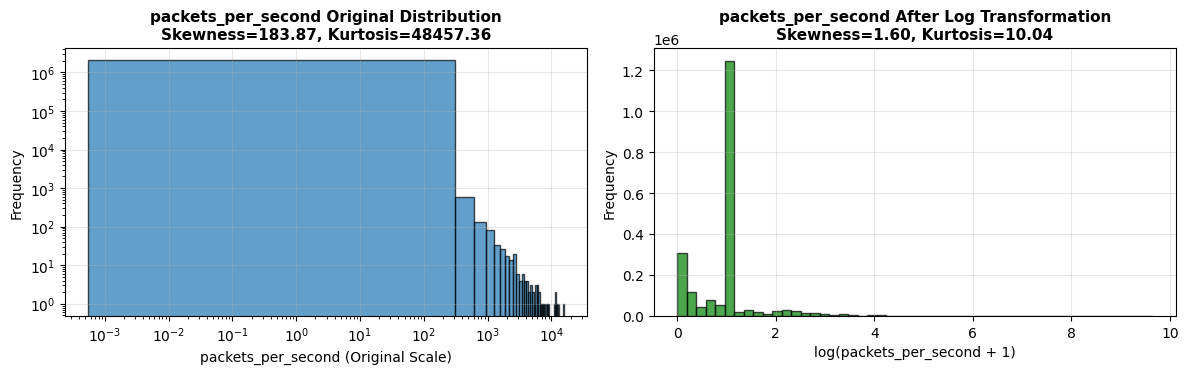


【長尾分佈摘要】
  Dur: 偏度=2.83, 峰度=9.52 (長尾分佈)
  TotBytes: 偏度=428.48, 峰度=212537.49 (長尾分佈)
  TotPkts: 偏度=1115.83, 峰度=1433080.65 (長尾分佈)
  SrcBytes: 偏度=1086.14, 峰度=1361148.01 (長尾分佈)
  DstBytes: 偏度=470.18, 峰度=255846.13 (長尾分佈)
  flow_ratio: 偏度=853.06, 峰度=817264.85 (長尾分佈)
  bytes_symmetry: 偏度=968.23, 峰度=1090655.94 (長尾分佈)
  bytes_per_second: 偏度=215.08, 峰度=68305.50 (長尾分佈)
  packets_per_second: 偏度=183.87, 峰度=48457.36 (長尾分佈)


In [5]:
# 提取特徵（階段1：基本時間特徵）
# extract_features 已從 src.features 導入（自動過濾 PySpark 冗長訊息）

# 預設使用階段1（time_feature_stage=1）
# 階段1包含：基本時間特徵（hour, day_of_week, is_weekend 等）
features_df = extract_features(df, include_time_features=True, time_feature_stage=1)

print(f"✅ 特徵提取完成（階段1）：{len(features_df):,} 筆，{len(features_df.columns)} 個特徵")
print(f"\n新增的特徵：")
new_features = [col for col in features_df.columns if col not in df.columns]
print(new_features)
print(f"\n💡 提示：這是階段1的特徵，後續章節將展示階段3和階段4的聚合特徵")

# 長尾分佈分析
print("\n" + "=" * 60)
print("【長尾分佈分析】")
print("=" * 60)
long_tail_results = analyze_long_tail_distribution(
    features_df, 
    show_plots=True
)

# 顯示摘要
print("\n【長尾分佈摘要】")
for feature, stats_dict in long_tail_results.items():
    if stats_dict['is_long_tail']:
        print(f"  {feature}: 偏度={stats_dict['skewness']:.2f}, "
              f"峰度={stats_dict['kurtosis']:.2f} (長尾分佈)")

In [6]:
## UDP/TCP 切分分析

## 分析不同協議的流量特徵差異，為後續的協議分組訓練做準備。

# 分離 UDP 和 TCP 流量
print("=" * 60)
print("【UDP/TCP 數據】")
print("=" * 60)

udp_df = features_df[features_df['Proto'].str.lower() == 'udp'].copy()
tcp_df = features_df[features_df['Proto'].str.lower() == 'tcp'].copy()

print(f"\nUDP 流量: {len(udp_df):,} 筆 ({len(udp_df)/len(features_df)*100:.2f}%)")
print(f"TCP 流量: {len(tcp_df):,} 筆 ({len(tcp_df)/len(features_df)*100:.2f}%)")
print(f"其他協議: {len(features_df) - len(udp_df) - len(tcp_df):,} 筆")

【UDP/TCP 數據】

UDP 流量: 1,629,194 筆 (78.04%)
TCP 流量: 431,554 筆 (20.67%)
其他協議: 26,760 筆


【UDP 流量分析】

【特徵分類】
   時間相關特徵：13 個
   非時間特徵：16 個

【過濾無變異性特徵】
   移除 8 個無變異性特徵：
   - 時間特徵中的常數/低變異數 (8 個): ['day_of_week', 'day_of_month', 'is_weekend', 'is_night', 'sin_day_of_week', 'cos_day_of_week', 'sin_day_of_month', 'cos_day_of_month']

【UDP 流量統計 - 非時間特徵】
          Dur   Sport   Dport    sTos    dTos  TotPkts TotBytes SrcBytes  \
count   1.63M   1.63M   1.63M   1.63M   1.63M    1.63M    1.63M    1.63M   
mean   341.53  37,079   7,550  0.0026  0.0004    17.84   12,810    3,862   
std    900.27  19,507  12,199  0.3748  0.0342   928.65  711,145  552,950   
min    0.0000  0.0000  0.0000  0.0000  0.0000     1.00    60.00   0.0000   
25%    0.0003  17,975   53.00  0.0000  0.0000     2.00   214.00    76.00   
50%    0.0006  41,804   53.00  0.0000  0.0000     2.00   237.00    81.00   
75%    0.1603  53,454  12,114  0.0000  0.0000     2.00   355.00   136.00   
max     3,600  65,535  65,535  192.00    3.00  779,943  720.34M  618.13M   

      DstBytes flow_ratio bytes_symmetry src_ratio dst_r

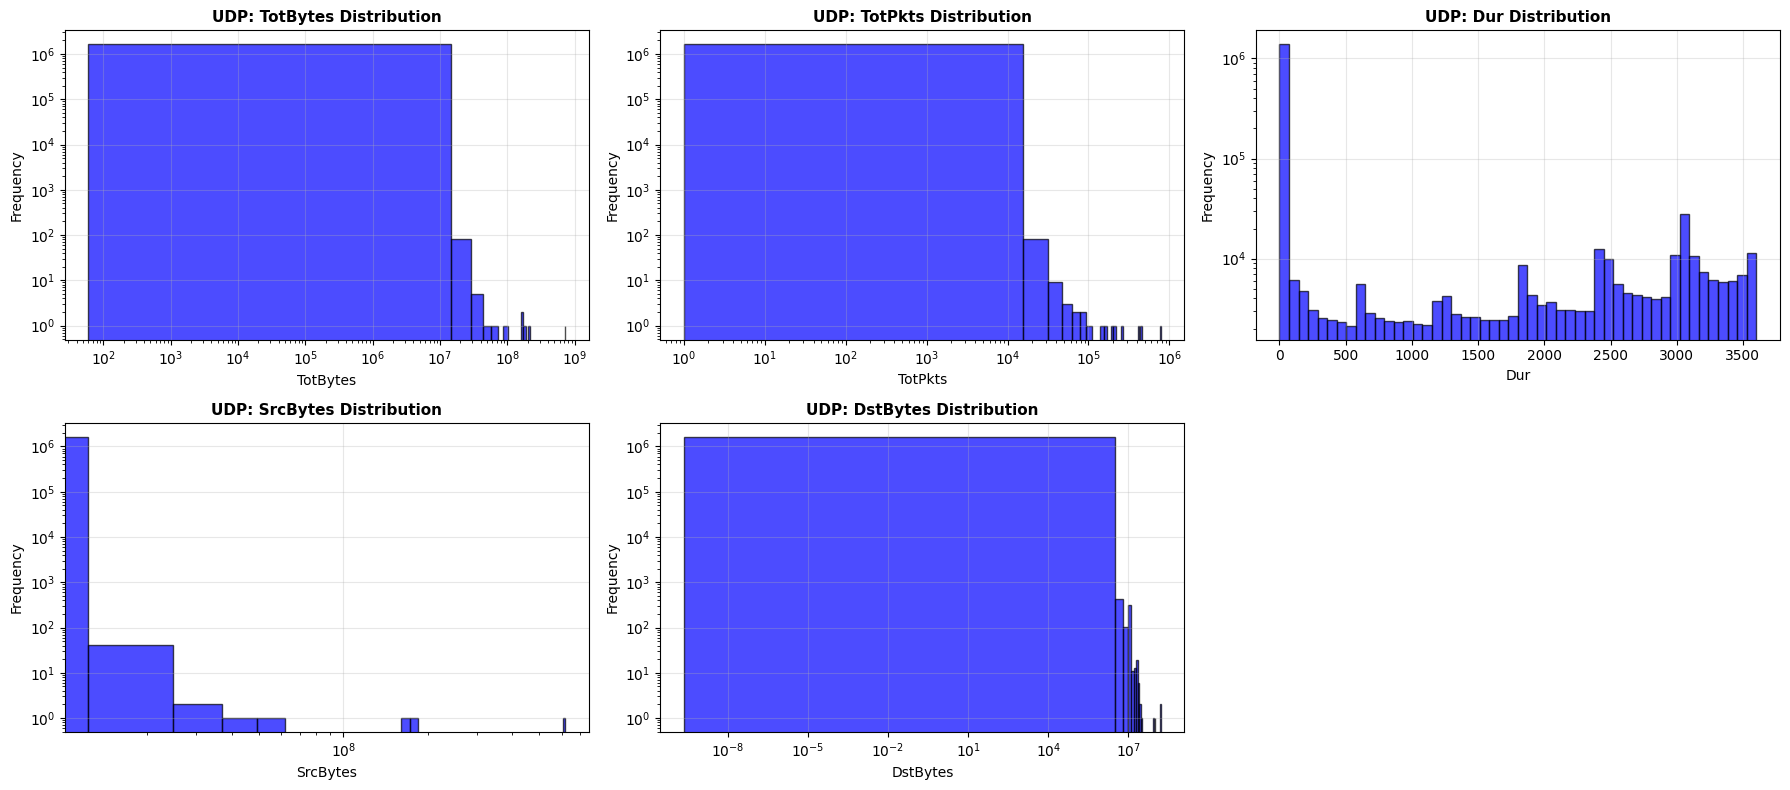

In [7]:
# UDP 流量分析
print("=" * 60)
print("【UDP 流量分析】")
print("=" * 60)

if len(udp_df) > 0:
    # 定義時間相關特徵列表
    time_related_features = [
        'hour', 'day_of_week', 'day_of_month',
        'is_weekend', 'is_work_hour', 'is_night',
        'sin_hour', 'cos_hour',
        'sin_day_of_week', 'cos_day_of_week',
        'sin_day_of_month', 'cos_day_of_month',
        'is_scanning',  # 雖然是行為標記，但與時間模式相關
        'time_since_last_flow', 'time_to_next_flow',
        'flows_per_minute_by_src', 'unique_dst_per_minute_by_src',
        'unique_dport_per_minute_by_src', 'total_bytes_per_minute_by_src'
    ]
    
    # 基本統計
    numeric_cols = udp_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # 分離時間特徵和非時間特徵
    time_features = [col for col in numeric_cols if col in time_related_features]
    non_time_features = [col for col in numeric_cols if col not in time_related_features]
    
    print(f"\n【特徵分類】")
    print(f"   時間相關特徵：{len(time_features)} 個")
    print(f"   非時間特徵：{len(non_time_features)} 個")
    
    # 🔥 過濾常數特徵和低變異數特徵（分別處理時間和非時間特徵）
    print("\n【過濾無變異性特徵】")
    constant_features = []
    low_variance_features = []
    variance_threshold = 1e-6
    
    # 檢查所有特徵
    all_features_to_check = numeric_cols
    for col in all_features_to_check:
        if col in udp_df.columns:
            # 檢查常數特徵（只有一個唯一值）
            if udp_df[col].nunique() <= 1:
                constant_features.append(col)
            # 檢查低變異數特徵
            elif udp_df[col].var() < variance_threshold:
                low_variance_features.append(col)
    
    # 移除這些特徵
    features_to_remove = constant_features + low_variance_features
    if features_to_remove:
        print(f"   移除 {len(features_to_remove)} 個無變異性特徵：")
        # 分組顯示
        time_removed = [f for f in features_to_remove if f in time_related_features]
        non_time_removed = [f for f in features_to_remove if f not in time_related_features]
        
        if time_removed:
            print(f"   - 時間特徵中的常數/低變異數 ({len(time_removed)} 個): {time_removed}")
        if non_time_removed:
            print(f"   - 非時間特徵中的常數/低變異數 ({len(non_time_removed)} 個): {non_time_removed}")
        
        numeric_cols = [col for col in numeric_cols if col not in features_to_remove]
        time_features = [col for col in time_features if col not in features_to_remove]
        non_time_features = [col for col in non_time_features if col not in features_to_remove]
    else:
        print("   ✅ 沒有發現無變異性特徵")
    
    # 🔥 格式化數字顯示
    def format_number(x):
        """格式化數字：小數用逗號分隔，大數用科學記號但更易讀"""
        if pd.isna(x):
            return x
        abs_x = abs(x)
        if abs_x < 1:
            return f'{x:.4f}'
        elif abs_x < 1000:
            return f'{x:.2f}'
        elif abs_x < 1e6:
            return f'{x:,.0f}'
        elif abs_x < 1e9:
            return f'{x/1e6:.2f}M'  # 百萬
        elif abs_x < 1e12:
            return f'{x/1e9:.2f}B'  # 十億
        else:
            return f'{x:.2e}'
    
    # 分別顯示時間特徵和非時間特徵的統計
    print("\n" + "=" * 60)
    print("【UDP 流量統計 - 非時間特徵】")
    print("=" * 60)
    if non_time_features:
        non_time_stats = udp_df[non_time_features].describe()
        non_time_stats_formatted = non_time_stats.applymap(format_number)
        print(non_time_stats_formatted)
    else:
        print("   ⚠️ 沒有非時間特徵")
    
    print("\n" + "=" * 60)
    print("【UDP 流量統計 - 時間相關特徵】")
    print("=" * 60)
    if time_features:
        time_stats = udp_df[time_features].describe()
        time_stats_formatted = time_stats.applymap(format_number)
        print(time_stats_formatted)
    else:
        print("   ⚠️ 沒有時間特徵")
    
    # 視覺化關鍵特徵（優先顯示非時間特徵）
    key_features = ['TotBytes', 'TotPkts', 'Dur', 'SrcBytes', 'DstBytes']
    available_features = [f for f in key_features if f in numeric_cols]
    
    if len(available_features) > 0:
        n_features = len(available_features)
        n_cols = min(3, n_features)
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_features == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for idx, feature in enumerate(available_features):
            ax = axes[idx]
            values = udp_df[feature].dropna()
            if len(values) > 0:
                ax.hist(values, bins=50, alpha=0.7, color='blue', edgecolor='black')
                ax.set_xlabel(feature, fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                ax.set_title(f'UDP: {feature} Distribution', fontsize=11, fontweight='bold')
                ax.set_yscale('log')
                if feature in ['TotBytes', 'TotPkts', 'SrcBytes', 'DstBytes']:
                    ax.set_xscale('log')
                ax.grid(True, alpha=0.3)
        
        # 隱藏多餘的子圖
        for idx in range(n_features, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ 沒有 UDP 流量數據")

【TCP 流量分析】

【特徵分類】
   時間相關特徵：13 個
   非時間特徵：16 個

【過濾無變異性特徵】
   移除 8 個無變異性特徵：
   - 時間特徵中的常數/低變異數 (8 個): ['day_of_week', 'day_of_month', 'is_weekend', 'is_night', 'sin_day_of_week', 'cos_day_of_week', 'sin_day_of_month', 'cos_day_of_month']

【TCP 流量統計 - 非時間特徵】
           Dur    Sport    Dport     sTos     dTos  TotPkts TotBytes SrcBytes  \
count  431,554  431,554  431,554  431,554  431,554  431,554  431,554  431,554   
mean    102.65   29,589    3,498   0.0003   0.0002   199.35  140,273   20,920   
std     460.00   23,876   10,855   0.0274   0.0209   27,697   11.76M    3.46M   
min     0.0000   0.0000   0.0000   0.0000   0.0000     1.00    60.00   0.0000   
25%     0.2072    3,413    80.00   0.0000   0.0000     6.00   412.00   242.00   
50%       3.00   36,876    80.00   0.0000   0.0000    12.00    2,370   971.00   
75%      19.24   52,486   443.00   0.0000   0.0000    25.00    9,472    2,189   
max      3,600   65,535   65,535     3.00     3.00   16.58M    3.25B    2.13B   

      DstBy

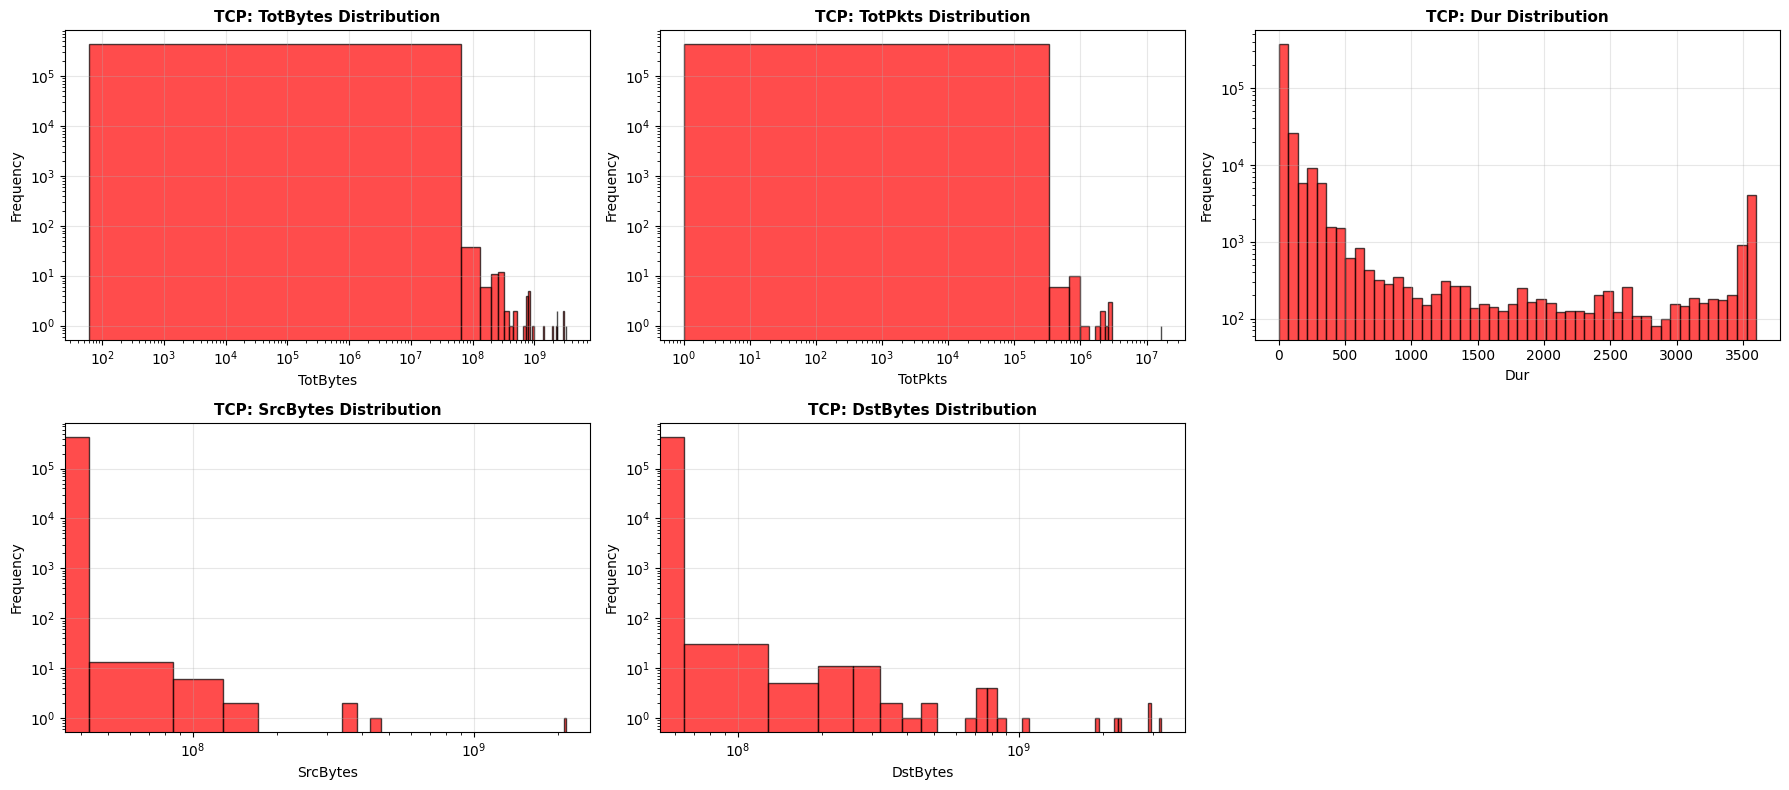

In [8]:
# TCP 流量分析
print("=" * 60)
print("【TCP 流量分析】")
print("=" * 60)

if len(tcp_df) > 0:
    # 定義時間相關特徵列表
    time_related_features = [
        'hour', 'day_of_week', 'day_of_month',
        'is_weekend', 'is_work_hour', 'is_night',
        'sin_hour', 'cos_hour',
        'sin_day_of_week', 'cos_day_of_week',
        'sin_day_of_month', 'cos_day_of_month',
        'is_scanning',  # 雖然是行為標記，但與時間模式相關
        'time_since_last_flow', 'time_to_next_flow',
        'flows_per_minute_by_src', 'unique_dst_per_minute_by_src',
        'unique_dport_per_minute_by_src', 'total_bytes_per_minute_by_src'
    ]
    
    # 基本統計
    numeric_cols = tcp_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # 分離時間特徵和非時間特徵
    time_features = [col for col in numeric_cols if col in time_related_features]
    non_time_features = [col for col in numeric_cols if col not in time_related_features]
    
    print(f"\n【特徵分類】")
    print(f"   時間相關特徵：{len(time_features)} 個")
    print(f"   非時間特徵：{len(non_time_features)} 個")
    
    # 🔥 過濾常數特徵和低變異數特徵（分別處理時間和非時間特徵）
    print("\n【過濾無變異性特徵】")
    constant_features = []
    low_variance_features = []
    variance_threshold = 1e-6
    
    # 檢查所有特徵
    all_features_to_check = numeric_cols
    for col in all_features_to_check:
        if col in tcp_df.columns:
            # 檢查常數特徵（只有一個唯一值）
            if tcp_df[col].nunique() <= 1:
                constant_features.append(col)
            # 檢查低變異數特徵
            elif tcp_df[col].var() < variance_threshold:
                low_variance_features.append(col)
    
    # 移除這些特徵
    features_to_remove = constant_features + low_variance_features
    if features_to_remove:
        print(f"   移除 {len(features_to_remove)} 個無變異性特徵：")
        # 分組顯示
        time_removed = [f for f in features_to_remove if f in time_related_features]
        non_time_removed = [f for f in features_to_remove if f not in time_related_features]
        
        if time_removed:
            print(f"   - 時間特徵中的常數/低變異數 ({len(time_removed)} 個): {time_removed}")
        if non_time_removed:
            print(f"   - 非時間特徵中的常數/低變異數 ({len(non_time_removed)} 個): {non_time_removed}")
        
        numeric_cols = [col for col in numeric_cols if col not in features_to_remove]
        time_features = [col for col in time_features if col not in features_to_remove]
        non_time_features = [col for col in non_time_features if col not in features_to_remove]
    else:
        print("   ✅ 沒有發現無變異性特徵")
    
    # 🔥 格式化數字顯示
    def format_number(x):
        """格式化數字：小數用逗號分隔，大數用科學記號但更易讀"""
        if pd.isna(x):
            return x
        abs_x = abs(x)
        if abs_x < 1:
            return f'{x:.4f}'
        elif abs_x < 1000:
            return f'{x:.2f}'
        elif abs_x < 1e6:
            return f'{x:,.0f}'
        elif abs_x < 1e9:
            return f'{x/1e6:.2f}M'  # 百萬
        elif abs_x < 1e12:
            return f'{x/1e9:.2f}B'  # 十億
        else:
            return f'{x:.2e}'
    
    # 分別顯示時間特徵和非時間特徵的統計
    print("\n" + "=" * 60)
    print("【TCP 流量統計 - 非時間特徵】")
    print("=" * 60)
    if non_time_features:
        non_time_stats = tcp_df[non_time_features].describe()
        non_time_stats_formatted = non_time_stats.applymap(format_number)
        print(non_time_stats_formatted)
    else:
        print("   ⚠️ 沒有非時間特徵")
    
    print("\n" + "=" * 60)
    print("【TCP 流量統計 - 時間相關特徵】")
    print("=" * 60)
    if time_features:
        time_stats = tcp_df[time_features].describe()
        time_stats_formatted = time_stats.applymap(format_number)
        print(time_stats_formatted)
    else:
        print("   ⚠️ 沒有時間特徵")
    
    # 視覺化關鍵特徵（優先顯示非時間特徵）
    key_features = ['TotBytes', 'TotPkts', 'Dur', 'SrcBytes', 'DstBytes']
    available_features = [f for f in key_features if f in numeric_cols]
    
    if len(available_features) > 0:
        n_features = len(available_features)
        n_cols = min(3, n_features)
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_features == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for idx, feature in enumerate(available_features):
            ax = axes[idx]
            values = tcp_df[feature].dropna()
            if len(values) > 0:
                ax.hist(values, bins=50, alpha=0.7, color='red', edgecolor='black')
                ax.set_xlabel(feature, fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                ax.set_title(f'TCP: {feature} Distribution', fontsize=11, fontweight='bold')
                ax.set_yscale('log')
                if feature in ['TotBytes', 'TotPkts', 'SrcBytes', 'DstBytes']:
                    ax.set_xscale('log')
                ax.grid(True, alpha=0.3)
        
        # 隱藏多餘的子圖
        for idx in range(n_features, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ 沒有 TCP 流量數據")

## 長尾分佈分析詳情

展示我們如何發現長尾分佈，以及為什麼需要進行 Log 轉換。


In [9]:
# 詳細的長尾分佈分析
print("=" * 60)
print("【長尾分佈分析詳情】")
print("=" * 60)

# 直接使用 Cell 7 中已經計算好的 long_tail_results
if 'long_tail_results' not in globals():
    print("⚠️  警告：long_tail_results 未找到，請先執行 Cell 7")
    print("   正在重新計算...")
    from src.features import analyze_long_tail_distribution
    long_tail_results = analyze_long_tail_distribution(features_df, show_plots=False)
else:
    print("✅ 使用 Cell 7 中已計算的 long_tail_results")

if long_tail_results:
    # 建立摘要表格
    summary_data = []
    for feature, stats_dict in long_tail_results.items():
        summary_data.append({
            '特徵': feature,
            '偏度 (Skewness)': f"{stats_dict['skewness']:.2f}",
            '峰度 (Kurtosis)': f"{stats_dict['kurtosis']:.2f}",
            '平均': f"{stats_dict['mean']:.2f}",
            '中位數': f"{stats_dict['median']:.2f}",
            '是否為長尾': '是' if stats_dict['is_long_tail'] else '否'
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\n長尾分佈統計摘要：")
    print(summary_df.to_string(index=False))
    
    # 找出最嚴重的長尾分佈特徵
    long_tail_features = [
        (f, s) for f, s in long_tail_results.items() 
        if s['is_long_tail']
    ]
    long_tail_features.sort(key=lambda x: abs(x[1]['skewness']), reverse=True)
    
    print("\n【長尾分佈特徵（按偏度排序）】")
    for feature, stats_dict in long_tail_features[:10]:
        print(f"  {feature}: 偏度={stats_dict['skewness']:.2f}, "
              f"峰度={stats_dict['kurtosis']:.2f}")
        print(f"    平均={stats_dict['mean']:.2f}, 中位數={stats_dict['median']:.2f}")
        print(f"    95%分位數={stats_dict['q95']:.2f}, 99%分位數={stats_dict['q99']:.2f}")
        print()
else:
    print("⚠️ 未找到長尾分佈分析結果")


【長尾分佈分析詳情】
✅ 使用 Cell 7 中已計算的 long_tail_results

長尾分佈統計摘要：
                特徵 偏度 (Skewness) 峰度 (Kurtosis)       平均    中位數 是否為長尾
               Dur          2.83          9.52   294.60   0.00     是
          TotBytes        428.48     212537.49 39081.89 264.00     是
           TotPkts       1115.83    1433080.65    55.29   2.00     是
          SrcBytes       1086.14    1361148.01  7418.33  83.00     是
          DstBytes        470.18     255846.13 31663.56 138.00     是
        flow_ratio        853.06     817264.85   261.33   0.60     是
    bytes_symmetry        968.23    1090655.94    36.51   1.62     是
  bytes_per_second        215.08      68305.50  1462.49 213.94     是
packets_per_second        183.87      48457.36     3.26   2.00     是

【長尾分佈特徵（按偏度排序）】
  TotPkts: 偏度=1115.83, 峰度=1433080.65
    平均=55.29, 中位數=2.00
    95%分位數=31.00, 99%分位數=194.00

  SrcBytes: 偏度=1086.14, 峰度=1361148.01
    平均=7418.33, 中位數=83.00
    95%分位數=3020.00, 99%分位數=17156.00

  bytes_symmetry: 偏度=968.23, 峰度=1090655.9

## UDP/TCP 切分分析詳情

展示我們如何發現 UDP 和 TCP 流量的特徵差異，以及為什麼需要分別處理。


【UDP/TCP 切分分析詳情】
✅ 使用 Cell 8 中已定義的 udp_df 和 tcp_df

【關鍵特徵比較（UDP vs TCP）】
------------------------------------------------------------
TotBytes:
  UDP 平均: 12810.38
  TCP 平均: 140273.42
  比例 (UDP/TCP): 0.09

TotPkts:
  UDP 平均: 17.84
  TCP 平均: 199.35
  比例 (UDP/TCP): 0.09

Dur:
  UDP 平均: 341.53
  TCP 平均: 102.65
  比例 (UDP/TCP): 3.33

SrcBytes:
  UDP 平均: 3861.78
  TCP 平均: 20919.82
  比例 (UDP/TCP): 0.18

DstBytes:
  UDP 平均: 8948.60
  TCP 平均: 119353.61
  比例 (UDP/TCP): 0.07



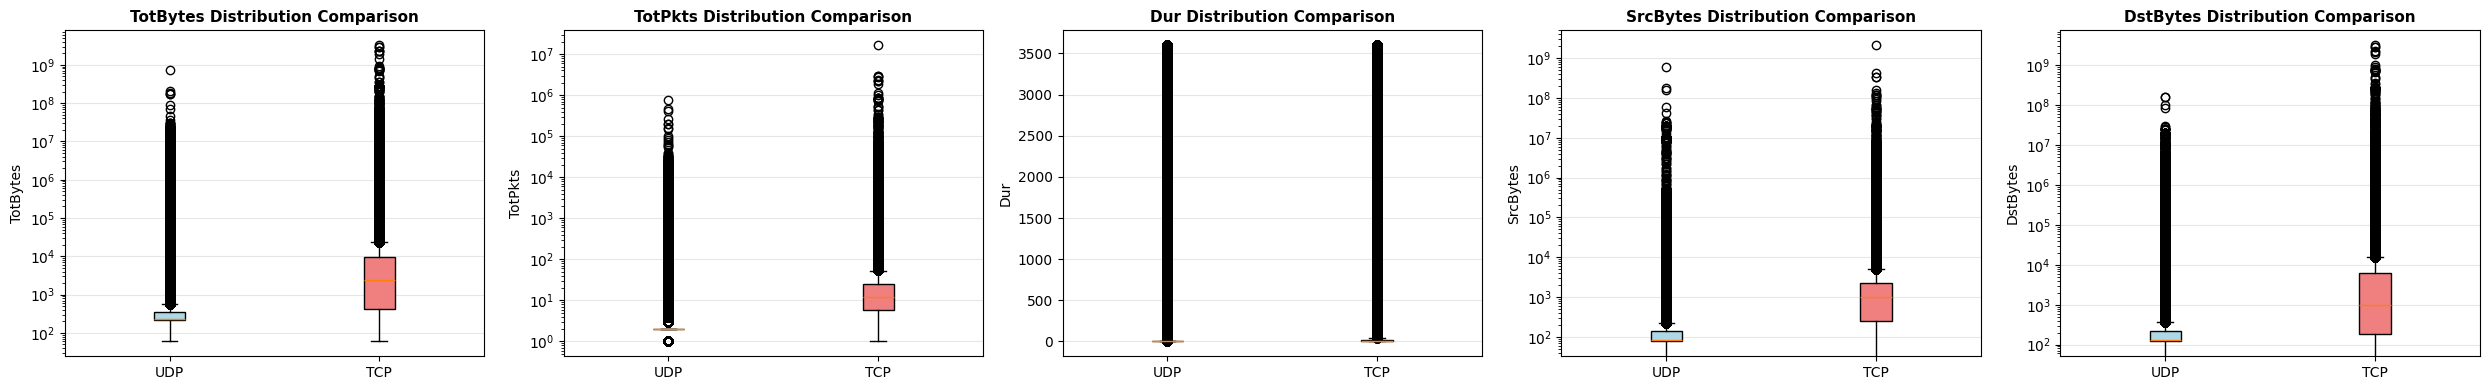

In [10]:
# 詳細的協議切分分析
print("=" * 60)
print("【UDP/TCP 切分分析詳情】")
print("=" * 60)

# 直接使用 Cell 8 中已經定義的 udp_df 和 tcp_df
if 'udp_df' not in globals() or 'tcp_df' not in globals():
    print("⚠️  警告：udp_df 或 tcp_df 未找到，請先執行 Cell 8")
    print("   正在重新計算...")
    udp_df = features_df[features_df['Proto'].str.lower() == 'udp'].copy()
    tcp_df = features_df[features_df['Proto'].str.lower() == 'tcp'].copy()
else:
    print("✅ 使用 Cell 8 中已定義的 udp_df 和 tcp_df")

# 計算協議統計結果
protocol_results = {
    'udp': udp_df.describe() if len(udp_df) > 0 else None,
    'tcp': tcp_df.describe() if len(tcp_df) > 0 else None
}

if protocol_results:
    # 比較關鍵特徵
    key_features = ['TotBytes', 'TotPkts', 'Dur', 'SrcBytes', 'DstBytes']
    available_features = [f for f in key_features if f in features_df.columns]
    
    print("\n【關鍵特徵比較（UDP vs TCP）】")
    print("-" * 60)
    
    for feature in available_features:
        if 'udp' in protocol_results and 'tcp' in protocol_results:
            udp_mean = protocol_results['udp'].loc['mean', feature] if feature in protocol_results['udp'].columns else None
            tcp_mean = protocol_results['tcp'].loc['mean', feature] if feature in protocol_results['tcp'].columns else None
            
            if udp_mean is not None and tcp_mean is not None:
                ratio = udp_mean / tcp_mean if tcp_mean != 0 else float('inf')
                print(f"{feature}:")
                print(f"  UDP 平均: {udp_mean:.2f}")
                print(f"  TCP 平均: {tcp_mean:.2f}")
                print(f"  比例 (UDP/TCP): {ratio:.2f}")
                print()
    
    # 視覺化比較
    if len(available_features) > 0:
        fig, axes = plt.subplots(1, len(available_features), figsize=(5*len(available_features), 4))
        if len(available_features) == 1:
            axes = [axes]
        
        for idx, feature in enumerate(available_features):
            ax = axes[idx]
            
            udp_values = features_df[features_df['Proto'].str.lower() == 'udp'][feature].dropna()
            tcp_values = features_df[features_df['Proto'].str.lower() == 'tcp'][feature].dropna()
            
            if len(udp_values) > 0 and len(tcp_values) > 0:
                # 箱線圖比較
                box_data = [udp_values, tcp_values]
                bp = ax.boxplot(box_data, tick_labels=['UDP', 'TCP'], patch_artist=True)
                bp['boxes'][0].set_facecolor('lightblue')
                bp['boxes'][1].set_facecolor('lightcoral')
                
                ax.set_ylabel(feature, fontsize=10)
                ax.set_title(f'{feature} Distribution Comparison', fontsize=11, fontweight='bold')
                if feature in ['TotBytes', 'TotPkts', 'SrcBytes', 'DstBytes']:
                    ax.set_yscale('log')
                ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ 未找到協議切分分析結果")


## 階段3：時間窗口聚合特徵（按源IP）

### 設計理念

**為什麼要按源IP聚合？**

單筆流記錄無法捕捉持續性攻擊行為。例如：
- **掃描行為**：一個源IP在短時間內連接大量不同的目標IP或端口
- **DDoS 攻擊**：一個源IP在短時間內產生大量流
- **異常流量**：一個源IP在短時間內傳輸異常大量的資料

**為什麼選擇1分鐘窗口？**

1分鐘是一個平衡點：
- 足夠短：能捕捉快速發生的攻擊（如掃描）
- 足夠長：能累積足夠的統計資訊，減少雜訊

### 聚合邏輯

**聚合維度**：`SrcAddr × 1分鐘時間窗口`

**聚合操作**：
- `flows_per_minute_by_src`：該源IP在該分鐘內的流數量
- `unique_dst_per_minute_by_src`：該源IP在該分鐘內連接的不同目標IP數量
- `unique_dport_per_minute_by_src`：該源IP在該分鐘內連接的不同目標端口數量
- `total_bytes_per_minute_by_src`：該源IP在該分鐘內的總位元組數

### 應用場景

- **掃描行為檢測**：`unique_dst_per_minute_by_src` 或 `unique_dport_per_minute_by_src` 異常高
- **DDoS 攻擊檢測**：`flows_per_minute_by_src` 異常高
- **異常流量檢測**：`total_bytes_per_minute_by_src` 異常高


【階段3：時間窗口聚合特徵提取】

✅ 階段3特徵提取完成：2,087,508 筆，42 個特徵

【階段3新增的聚合特徵】
  ✅ flows_per_minute_by_src
  ✅ unique_dst_per_minute_by_src
  ✅ unique_dport_per_minute_by_src
  ✅ total_bytes_per_minute_by_src

【異常源IP分析（Top 10 高流量源IP）】

每分鐘流數量最多的源IP：
  147.32.84.138: 9442 流/分鐘
  147.32.84.59: 2132 流/分鐘
  124.232.153.174: 968 流/分鐘
  211.155.231.207: 968 流/分鐘
  60.174.174.107: 966 流/分鐘
  122.226.12.150: 955 流/分鐘
  147.32.84.229: 828 流/分鐘
  70.37.110.238: 813 流/分鐘
  147.32.85.124: 693 流/分鐘
  147.32.86.165: 626 流/分鐘

【視覺化：flows_per_minute_by_src 分佈】


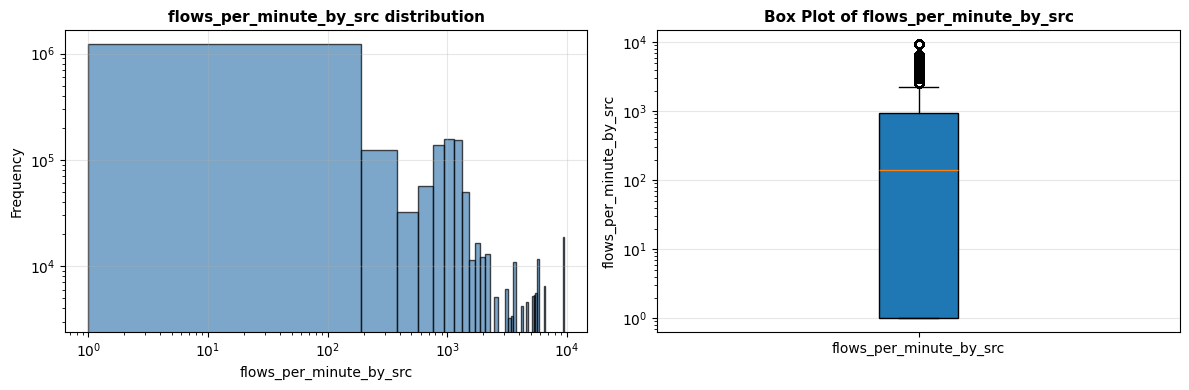


【關鍵發現】
  - 原始資料筆數：2,087,508
  - 階段3特徵筆數：2,087,508（資料筆數不變，新增聚合特徵欄位）
  - 階段3新增特徵數：4 個
  - 聚合特徵能捕捉源IP的行為模式，有助於識別掃描、DDoS 等持續性攻擊


In [11]:
# 提取階段3特徵（時間窗口聚合特徵）
print("=" * 60)
print("【階段3：時間窗口聚合特徵提取】")
print("=" * 60)

# 使用階段3特徵提取
features_stage3 = extract_features(
    df, 
    include_time_features=True,
    time_feature_stage=3  # 階段3：包含階段1-3的所有特徵
)

print(f"\n✅ 階段3特徵提取完成：{len(features_stage3):,} 筆，{len(features_stage3.columns)} 個特徵")

# 找出階段3新增的聚合特徵
stage3_features = [
    'flows_per_minute_by_src',
    'unique_dst_per_minute_by_src',
    'unique_dport_per_minute_by_src',
    'total_bytes_per_minute_by_src'
]

print(f"\n【階段3新增的聚合特徵】")
for feat in stage3_features:
    if feat in features_stage3.columns:
        print(f"  ✅ {feat}")
        # 基本統計
        # values = features_stage3[feat].dropna()
        # if len(values) > 0:
            # print(f"     範圍：[{values.min():.2f}, {values.max():.2f}]")
            # print(f"     平均：{values.mean():.2f}, 中位數：{values.median():.2f}")
            # print(f"     95%分位數：{values.quantile(0.95):.2f}, 99%分位數：{values.quantile(0.99):.2f}")
    else:
        print(f"  ⚠️  {feat} (未找到)")

# 分析異常源IP（高流量的源IP）
print(f"\n【異常源IP分析（Top 10 高流量源IP）】")
if 'flows_per_minute_by_src' in features_stage3.columns:
    # 找出每分鐘流數量最多的源IP
    top_src_ips = features_stage3.groupby('SrcAddr')['flows_per_minute_by_src'].max().nlargest(10)
    print("\n每分鐘流數量最多的源IP：")
    for src_ip, max_flows in top_src_ips.items():
        print(f"  {src_ip}: {max_flows:.0f} 流/分鐘")

# 視覺化：flows_per_minute_by_src 的分佈
if 'flows_per_minute_by_src' in features_stage3.columns:
    print(f"\n【視覺化：flows_per_minute_by_src 分佈】")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    values = features_stage3['flows_per_minute_by_src'].dropna()
    
    # 直方圖（對數尺度）
    axes[0].hist(values, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('flows_per_minute_by_src', fontsize=10)
    axes[0].set_ylabel('Frequency', fontsize=10)
    axes[0].set_title('flows_per_minute_by_src distribution', fontsize=11, fontweight='bold')
    axes[0].set_yscale('log')
    axes[0].set_xscale('log')
    axes[0].grid(True, alpha=0.3)
    
    # 箱線圖
    axes[1].boxplot([values], tick_labels=['flows_per_minute_by_src'], patch_artist=True)
    axes[1].set_ylabel('flows_per_minute_by_src', fontsize=10)
    axes[1].set_title('Box Plot of flows_per_minute_by_src', fontsize=11, fontweight='bold')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# 關鍵發現
print(f"\n【關鍵發現】")
print(f"  - 原始資料筆數：{len(df):,}")
print(f"  - 階段3特徵筆數：{len(features_stage3):,}（資料筆數不變，新增聚合特徵欄位）")
print(f"  - 階段3新增特徵數：{len([f for f in stage3_features if f in features_stage3.columns])} 個")
print(f"  - 聚合特徵能捕捉源IP的行為模式，有助於識別掃描、DDoS 等持續性攻擊")


## 階段4：雙向流 Pair 聚合特徵（按IP Pair）

### 設計理念

**為什麼要按IP Pair聚合？**

階段3按源IP聚合，但無法捕捉雙向互動的模式。例如：
- **正常通訊**：A ↔ B 有雙向流量，對稱性高
- **單向流量異常**：A → B 有大量流量，但 B → A 很少（可能是外洩、掃描）
- **Session級別異常**：整個IP Pair的互動模式異常

**雙向流的概念**

- `(A, B)` 和 `(B, A)` 被視為同一 Pair
- 使用 `min(SrcAddr, DstAddr)` 和 `max(SrcAddr, DstAddr)` 標準化
- 聚合時會合併兩個方向的流量

### 聚合邏輯

**聚合維度**：`IP Pair × 1分鐘時間窗口`

**聚合操作**：
- `bidirectional_flow_count`：該 IP Pair 在時間窗口內的流數量（雙向合計）
- `bidirectional_total_bytes`：該 IP Pair 在時間窗口內的總位元組數（雙向合計）
- `bidirectional_total_packets`：該 IP Pair 在時間窗口內的總封包數（雙向合計）
- `bidirectional_total_src_bytes`：該 IP Pair 在時間窗口內的總上行位元組數
- `bidirectional_total_dst_bytes`：該 IP Pair 在時間窗口內的總下行位元組數
- `bidirectional_symmetry`：雙向流量對稱性（0-1，1表示完全對稱）
- `bidirectional_avg_bytes_per_flow`：平均每個流的位元組數
- `bidirectional_avg_packets_per_flow`：平均每個流的封包數

### 應用場景

- **正常通訊識別**：`bidirectional_symmetry` 接近 1
- **單向流量異常**：`bidirectional_symmetry` 接近 0（可能是外洩、掃描）
- **Session級別異常檢測**：整個IP Pair的互動模式異常


【階段4：雙向流 Pair 聚合特徵提取】






✅ 階段4特徵提取完成：2,087,508 筆，52 個特徵

【階段4新增的雙向流聚合特徵】
  ✅ bidirectional_flow_count
  ✅ bidirectional_total_bytes
  ✅ bidirectional_total_packets
  ✅ bidirectional_total_src_bytes
  ✅ bidirectional_total_dst_bytes
  ✅ bidirectional_symmetry
  ✅ bidirectional_avg_bytes_per_flow
  ✅ bidirectional_avg_packets_per_flow
  ✅ bidirectional_avg_duration

【雙向流量對稱性分析】
  平均對稱性：0.4532
  完全對稱（>0.9）：58,125 筆 (2.78%)
  不對稱（<0.1）：280,960 筆 (13.46%)

【視覺化：bidirectional_symmetry 分佈】


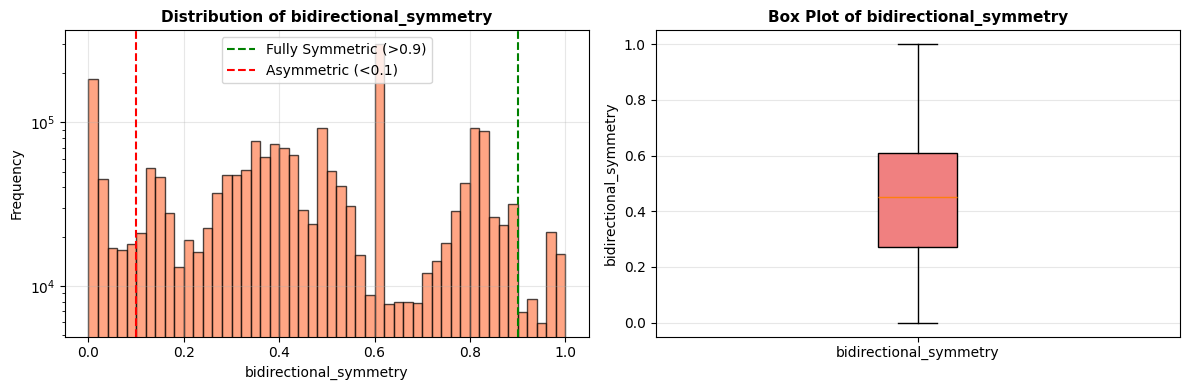


【關鍵發現】
  - 原始資料筆數：2,087,508
  - 階段4特徵筆數：2,087,508（資料筆數不變，新增聚合特徵欄位）
  - 階段4新增特徵數：9 個
  - 雙向流特徵能捕捉IP Pair的互動模式，有助於識別Session級別的異常
  - 對稱性特徵能區分正常通訊（高對稱性）和異常流量（低對稱性）


In [12]:
# 提取階段4特徵（雙向流 Pair 聚合特徵）
print("=" * 60)
print("【階段4：雙向流 Pair 聚合特徵提取】")
print("=" * 60)

try:
    # 使用階段4特徵提取（包含所有階段1-4的特徵）
    features_stage4 = extract_features(
        df, 
        include_time_features=True,
        time_feature_stage=4  # 階段4：包含階段1-4的所有特徵
    )
    
    print(f"\n✅ 階段4特徵提取完成：{len(features_stage4):,} 筆，{len(features_stage4.columns)} 個特徵")
    
    # 找出階段4新增的雙向流聚合特徵
    stage4_features = [
        'bidirectional_flow_count',
        'bidirectional_total_bytes',
        'bidirectional_total_packets',
        'bidirectional_total_src_bytes',
        'bidirectional_total_dst_bytes',
        'bidirectional_symmetry',
        'bidirectional_avg_bytes_per_flow',
        'bidirectional_avg_packets_per_flow',
        'bidirectional_avg_duration'
    ]
    
    print(f"\n【階段4新增的雙向流聚合特徵】")
    for feat in stage4_features:
        if feat in features_stage4.columns:
            print(f"  ✅ {feat}")
        else:
            print(f"  ⚠️  {feat} (未找到)")
    
    # 分析雙向流量對稱性（簡化輸出）
    if 'bidirectional_symmetry' in features_stage4.columns:
        print(f"\n【雙向流量對稱性分析】")
        symmetry_values = features_stage4['bidirectional_symmetry'].dropna()
        print(f"  平均對稱性：{symmetry_values.mean():.4f}")
        print(f"  完全對稱（>0.9）：{(symmetry_values > 0.9).sum():,} 筆 ({(symmetry_values > 0.9).sum()/len(symmetry_values)*100:.2f}%)")
        print(f"  不對稱（<0.1）：{(symmetry_values < 0.1).sum():,} 筆 ({(symmetry_values < 0.1).sum()/len(symmetry_values)*100:.2f}%)")
    
    # 視覺化：bidirectional_symmetry 的分佈
    if 'bidirectional_symmetry' in features_stage4.columns:
        print(f"\n【視覺化：bidirectional_symmetry 分佈】")
        visualize_bidirectional_symmetry(features_stage4, 'bidirectional_symmetry')
    
    # 關鍵發現
    print(f"\n【關鍵發現】")
    print(f"  - 原始資料筆數：{len(df):,}")
    print(f"  - 階段4特徵筆數：{len(features_stage4):,}（資料筆數不變，新增聚合特徵欄位）")
    print(f"  - 階段4新增特徵數：{len([f for f in stage4_features if f in features_stage4.columns])} 個")
    print(f"  - 雙向流特徵能捕捉IP Pair的互動模式，有助於識別Session級別的異常")
    print(f"  - 對稱性特徵能區分正常通訊（高對稱性）和異常流量（低對稱性）")
    
except Exception as e:
    print(f"\n⚠️  階段4特徵提取失敗：{e}")
    print("   可能原因：")
    print("   1. PySpark 未安裝或配置不正確")
    print("   2. 記憶體不足")
    print("   3. Windows 環境下的 PySpark 相容性問題")
    print("\n   建議：")
    print("   - 檢查 PySpark 安裝：pip install pyspark")
    print("   - 如果 PySpark 不可用，系統會自動降級到 Pandas 版本")
    print("   - 或者先使用階段3特徵進行分析")